In [ ]:
import torch
import types
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam

from PIL import Image
from einops import rearrange
from demo.modify_llama import *

import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch.nn.functional as F
from scipy.ndimage import filters
from torch import nn

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:
# set seed
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [3]:

model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True,
                                             ignore_mismatched_sizes=True, # Adding CLS token, will be handled manually
                                             output_attentions=True
                                             )

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Usage Class Token:  True


Some weights of MultiModalityCausalLM were not initialized from the model checkpoint at deepseek-ai/Janus-Pro-1B and are newly initialized: ['vision_model.vision_tower.cls_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MultiModalityCausalLM were not initialized from the model checkpoint at deepseek-ai/Janus-Pro-1B and are newly initialized because the shapes did not match:
- vision_model.vision_tower.pos_embed: found shape torch.Size([1, 576, 1024]) in the checkpoint and torch.Size([1, 577, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be 

In [4]:
print(vl_gpt.language_model.model.layers[0].self_attn)

LlamaAttention(
  (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
  (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
  (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
  (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
)


In [5]:
print(config.language_config)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 16384,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.1",
  "use_cache": true,
  "vocab_size": 102400
}



In [6]:
class AttentionGuidedCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.activations = []
        self.hooks = []
        self._modify_layers()
        self._register_hooks_activations()

    def _register_hooks(self):
        """ Registers hooks to extract activations and gradients from ALL attention layers. """
        for layer in self.target_layers:
            self.hooks.append(layer.register_forward_hook(self._forward_hook))
            self.hooks.append(layer.register_full_backward_hook(self._backward_hook))

    def _register_hooks_activations(self):
        for layer in self.target_layers:
            self.hooks.append(layer.register_forward_hook(self._forward_activate_hooks))

    def _forward_hook(self, module, input, output):
        """ Stores attention maps (before softmax) """
        attn_output, attn_weights = output  # Unpack outputs
    
        # Ensure attention weights require gradients
        # attn_weights.retain_grad()
        attn_weights = attn_weights.clone().detach().requires_grad_(True)
        module.attn_weights = attn_weights
        self.activations.append((attn_output, attn_weights))

    def _backward_hook(self, module, grad_in, grad_out):
        """ Stores gradients """
        # `grad_output[0]` is the gradient of attention_output (dL/dY)
        # module.attn_outputs_grad = grad_out[0]  
        # print("num_grads: ", len(grad_out))
        print("grad_output: ", grad_out[0].shape)
        # print("grad_weight: ", grad_out[1].shape)

        # self.gradients.append(grad_out)

        # Manually recompute gradient of attention weights
        # if hasattr(module, "attn_weights"):
        #     attn_weights = module.attn_weights  # [1, 16, 629, 629]  (heads, seq_len, seq_len)
        #     attn_outputs_grad = module.attn_outputs_grad  # [1, 629, 2048]

        #     # Compute gradient approximation (Chain Rule)
        #     # ∂L / ∂attn_weights ≈ attn_outputs_grad ⊗ Value Projection (v_proj)
        #     # Extract value projection V
        #     V = module.v_proj.weight  # Shape: [hidden_dim, hidden_dim]

        #     # Reshape V for multi-head attention
        #     V = V.view(module.config.num_attention_heads, module.head_dim, -1).transpose(1, 2)  # Shape: [heads, head_dim, hidden_dim]

        #     print("shape of mats: ", attn_outputs_grad.shape, V.shape)

        #     # Compute attn_weights_grad using chain rule: dL/dA = dL/dO @ V^T
        #     module.attn_weights_grad = torch.matmul(attn_outputs_grad, V.transpose(-1, -2))
            
        #     self.gradients.append((grad_out[0], module.attn_weights_grad))
        #     print(f"✅ Computed Attention Weights Gradient Shape: {module.attn_weights_grad.shape}")
        # else:
        #     print("❌ Error: attn_weights not found in module. Ensure forward_hook stores it.")

    def _forward_activate_hooks(self, module, input, output):
        attn_output, attn_weights = output  # Unpack outputs
        module.save_attn_map(attn_weights)
        attn_weights.register_hook(module.save_attn_gradients)

    def _modify_layers(self):
        for layer in self.target_layers:
            setattr(layer, "attn_gradients", None)
            setattr(layer, "attention_map", None)

            layer.save_attn_gradients = types.MethodType(save_attn_gradients, layer)
            layer.get_attn_gradients = types.MethodType(get_attn_gradients, layer)
            layer.save_attn_map = types.MethodType(save_attn_map, layer)
            layer.get_attn_map = types.MethodType(get_attn_map, layer)
            
    def remove_hooks(self):
        """ Remove hooks after usage. """
        for hook in self.hooks:
            hook.remove()

    # def normalize(self, arr):
    #     arr = F.relu(arr)
    #     arr = arr - arr.min()
    #     arr = arr / (arr.max() - arr.min())
    #     return arr
    
    def generate_cam(self, input_tensor, class_idx=None):
        raise NotImplementedError

In [7]:
class AttentionGuidedCAMJanus(AttentionGuidedCAM):
    def __init__(self, model, target_layers):
        self.target_layers = target_layers
        super().__init__(model)


    def generate_cam(self, input_tensor, tokenizer, temperature, top_p, class_idx=None, visual_pooling_method="CLS"):
        """ Generates Grad-CAM heatmap for ViT. """
        
        
        # Forward pass
        image_embeddings, inputs_embeddings, outputs = self.model(input_tensor, tokenizer, temperature, top_p)


        input_ids = input_tensor.input_ids

        # Pooling
        if visual_pooling_method == "CLS":
            image_embeddings_pooled = image_embeddings[:, 0, :]
        elif visual_pooling_method == "avg":
            image_embeddings_pooled = image_embeddings[:, 1:, :].mean(dim=1) # end of image: 618
        elif visual_pooling_method == "max":
            image_embeddings_pooled, _ = image_embeddings[:, 1:, :].max(dim=1)

        
        


        # inputs_embeddings_pooled = inputs_embeddings[:, 620: -4].mean(dim=1)

        # image_embeddings_pooled = outputs.logits[input_tensor.images_seq_mask].unsqueeze(0).mean(dim=1)

        # print("image_embeddings_shape: ", image_embeddings_pooled.shape)



        # inputs_embeddings_pooled = inputs_embeddings[
        #     torch.arange(inputs_embeddings.shape[0], device=inputs_embeddings.device),
        #     input_ids.to(dtype=torch.int, device=inputs_embeddings.device).argmax(dim=-1),
        # ]


        # Backpropagate to get gradients
        # final = nn.Linear(102400, 1).to(dtype).cuda()
        loss = outputs.logits.sum(dim=-1)
        self.model.zero_grad()
        loss[0].sum().backward()
        # image_embeddings_pooled.backward(inputs_embeddings_pooled, retain_graph=True)
        # similarity = F.cosine_similarity(image_embeddings_mean, inputs_embeddings_mean, dim=-1)
        # similarity.backward()

        # Aggregate activations and gradients from ALL layers
        cam_sum = None

        self.activations = [layer.get_attn_map() for layer in self.target_layers]
        self.gradients = [layer.get_attn_gradients() for layer in self.target_layers]

        for act, grad in zip(self.activations, self.gradients):
            # act = torch.sigmoid(act)
            print("act:", act)
            print(len(act))
            print("act_shape:", act.shape)
            # print("act1_shape:", act[1].shape)
            
            act = F.relu(act.mean(dim=1))
 

            # Compute mean of gradients
            print("grad:", grad)
            print(len(grad))
            print("grad_shape:", grad.shape)
            grad_weights = grad.mean(dim=1)

            print("act shape", act.shape)
            print("grad_weights shape", grad_weights.shape)

            # cam, _ = (act * grad_weights).max(dim=-1)
            # cam = act * grad_weights
            cam = act * grad_weights
            print(cam.shape)

            # Sum across all layers
            if cam_sum is None:
                cam_sum = cam
            else:
                cam_sum += cam  

        # Normalize
        cam_sum = F.relu(cam_sum)
        cam_sum = cam_sum - cam_sum.min()
        cam_sum = cam_sum / cam_sum.max()

        # thresholding
        cam_sum = cam_sum.to(torch.float32)
        percentile = torch.quantile(cam_sum, 0.2)  # Adjust threshold dynamically
        cam_sum[cam_sum < percentile] = 0

        # Reshape
        # if visual_pooling_method == "CLS":
        # cam_sum = cam_sum[0, 1:]

        # cam_sum shape: [1, seq_len, seq_len]
        cam_sum_lst = []
        cam_sum_raw = cam_sum
        for i in range(620, cam_sum_raw.shape[1]):
            cam_sum = cam_sum_raw[:, i, :] # shape: [1: seq_len]
            cam_sum = cam_sum[input_tensor.images_seq_mask].unsqueeze(0) # shape: [1, 576]
            print("cam_sum shape: ", cam_sum.shape)
            num_patches = cam_sum.shape[-1]  # Last dimension of CAM output
            grid_size = int(num_patches ** 0.5)
            print(f"Detected grid size: {grid_size}x{grid_size}")

            # Fix the reshaping step dynamically
            
            cam_sum = cam_sum.view(grid_size, grid_size)
            cam_sum_lst.append(cam_sum)


        return cam_sum_lst, grid_size, outputs

In [8]:
def multimodal_understanding(image, question, seed, top_p, temperature, target):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()


    for param in vl_gpt.parameters():
        param.requires_grad = True
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    

    # Get the last transformer block of the Vision Transformer (ViT)


    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)

    # print(prepare_inputs)

    print("generating guided gradcam...")
    

    # Compute the attributions.
    # target_layers = [block.norm1 for block in vl_gpt.vision_model.vision_tower.blocks]
    all_layers = [layer.self_attn for layer in vl_gpt.language_model.model.layers]
    layer_left = 9
    target_layers = all_layers[layer_left: layer_left + 1]

    # print("target_layers: ", target_layers[0].get_attn_gradients)

    gradcam = AttentionGuidedCAMJanus(vl_gpt, target_layers)
    cam_tensor_lst, grid_size, outputs = gradcam.generate_cam(prepare_inputs, tokenizer, temperature, top_p, target)

    input_ids = prepare_inputs.input_ids[0].cpu().tolist()
    input_ids_decoded = [tokenizer.decode([input_ids[i]]) for i in range(len(input_ids))]
    
    
    return cam_tensor_lst, input_ids_decoded, outputs, prepare_inputs

In [9]:
# IMG_PATH = "../images/doge.png"
# question = "Find the Visual Encoding text."

# IMG_PATH = "../images/AreaChart.png"
# question = "What is the coffee price in April 2019?"

# IMG_PATH = "../images/PieChart.png"
# question = "What is the market share of Xiaomi?"

# IMG_PATH = "../images/pie_chart.png"
# question = ""

IMG_PATH = "../images/cat_dog.png"
question = "where is the dog? How about cat?"


# question = "Text including coffee"

image = Image.open(IMG_PATH)
image_arr = np.array(image)
target_token_idx = 3
# target_token_idx = 7

cam_tensor_lst, input_ids_decoded, outputs, prepare_inputs = multimodal_understanding(image_arr, question, seed, 0.95, 0, target=target_token_idx)


generating guided gradcam...
Select Feature Methodology:  same
image_embeds shape:  torch.Size([1, 577, 2048])
inputs_embeds shape:  torch.Size([1, 633, 2048])
act: tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.8828e-01, 1.0498e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.8438e-01, 5.8594e-03, 8.2397e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.0078e-01, 1.0529e-03, 9.2697e-04,  ..., 1.6113e-01,
           0.0000e+00, 0.0000e+00],
          [3.9551e-02, 1.4725e-03, 1.4038e-03,  ..., 3.5400e-03,
           4.9805e-02, 0.0000e+00],
          [2.7734e-01, 1.0681e-03, 2.3956e-03,  ..., 6.6895e-02,
           1.2695e-01, 2.3193e-02]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3750e-01, 6.2012e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          

In [10]:
print(len(input_ids_decoded))

633


In [11]:
start=620
input_ids_decoded[start + target_token_idx]

' dog'

In [12]:
print(outputs.logits.shape)

torch.Size([1, 633, 102400])


In [13]:
prepare_inputs.keys()

dict_keys(['sft_format', 'input_ids', 'pixel_values', 'attention_mask', 'images_seq_mask', 'images_emb_mask'])

Generating Grad-CAM with shape: torch.Size([24, 24])


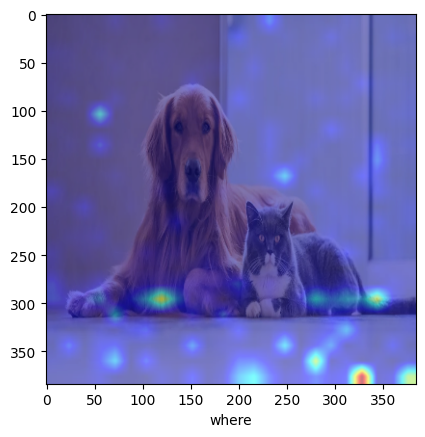

Generating Grad-CAM with shape: torch.Size([24, 24])


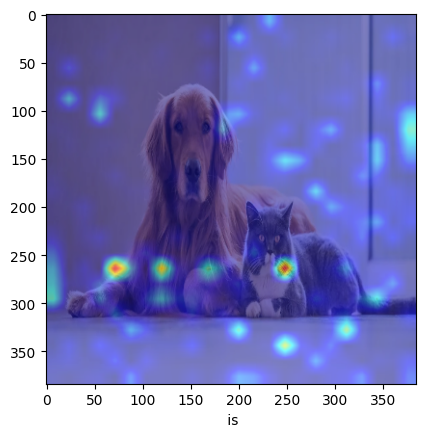

Generating Grad-CAM with shape: torch.Size([24, 24])


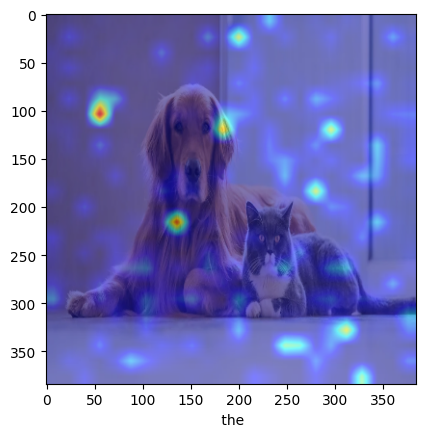

Generating Grad-CAM with shape: torch.Size([24, 24])


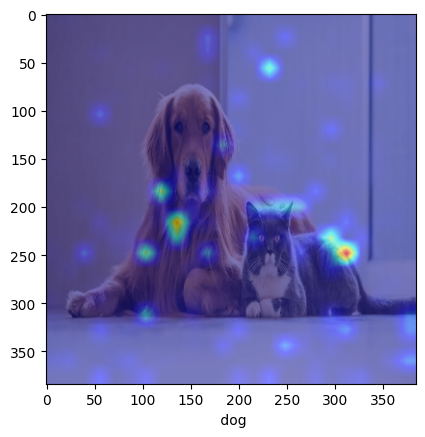

Generating Grad-CAM with shape: torch.Size([24, 24])


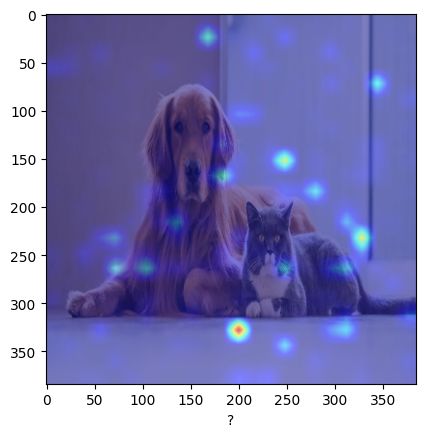

Generating Grad-CAM with shape: torch.Size([24, 24])


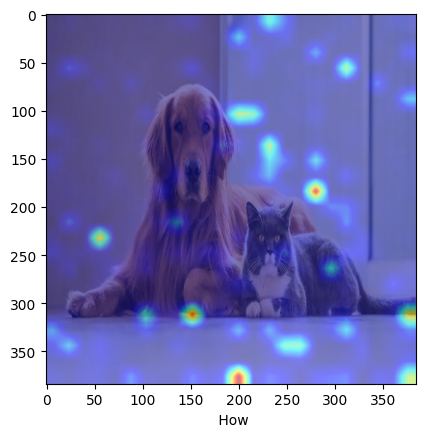

Generating Grad-CAM with shape: torch.Size([24, 24])


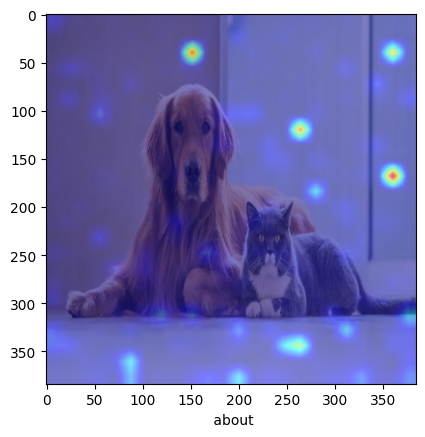

Generating Grad-CAM with shape: torch.Size([24, 24])


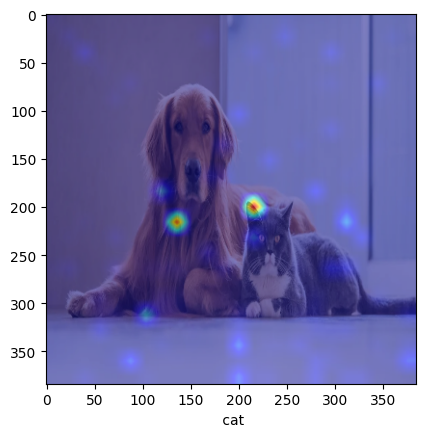

Generating Grad-CAM with shape: torch.Size([24, 24])


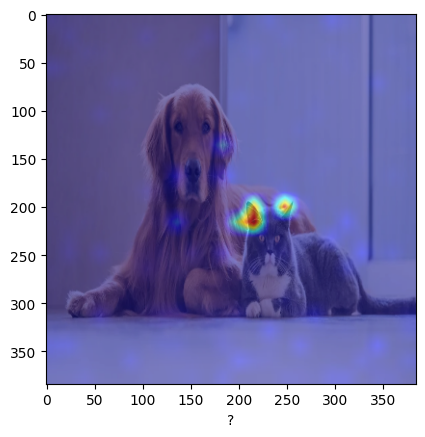

Generating Grad-CAM with shape: torch.Size([24, 24])


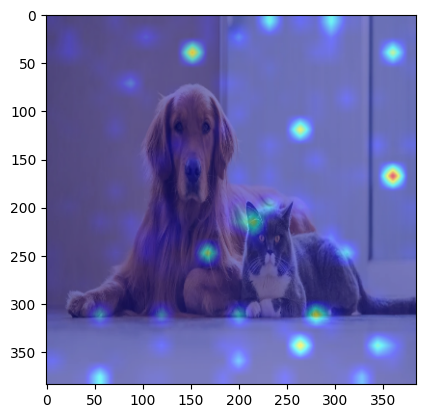

Generating Grad-CAM with shape: torch.Size([24, 24])


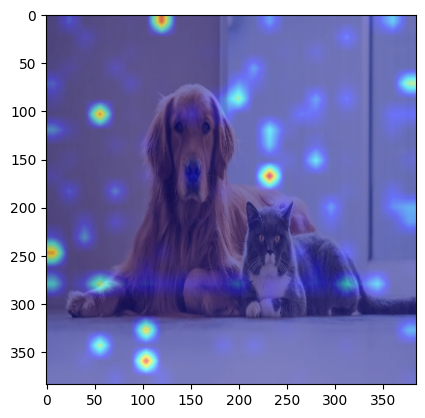

Generating Grad-CAM with shape: torch.Size([24, 24])


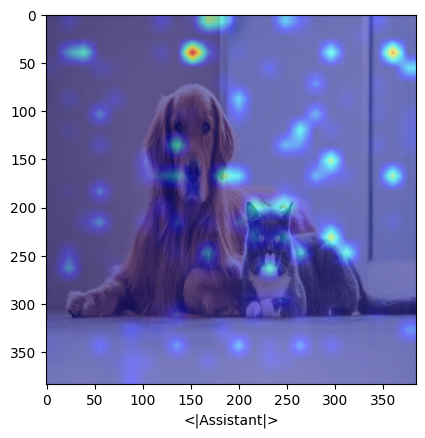

Generating Grad-CAM with shape: torch.Size([24, 24])


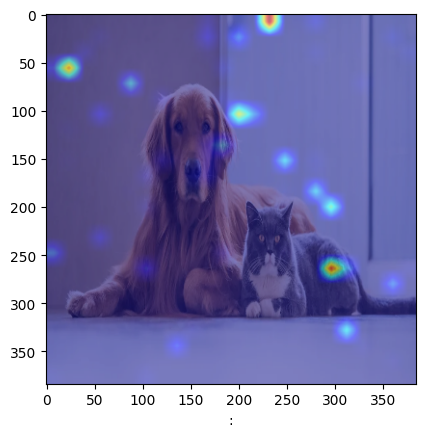

In [14]:
for i in range(len(cam_tensor_lst)):
    cam_tensor = cam_tensor_lst[i]
    cam_grid = cam_tensor.reshape(24, 24)

    cam = generate_gradcam(cam_grid, image)

    
    plt.imshow(cam)
    plt.xlabel(input_ids_decoded[start + i])
    plt.show(cam)

In [15]:
print(outputs.logits.shape)

torch.Size([1, 633, 102400])


In [16]:
print(prepare_inputs.images_seq_mask.shape)

torch.Size([1, 633])


In [17]:
masked_input = outputs.logits[prepare_inputs.images_seq_mask].unsqueeze(0)
print(masked_input.shape)

torch.Size([1, 576, 102400])


In [18]:
attention_scores = torch.stack(outputs.attentions)
attention_scores.shape

torch.Size([24, 1, 16, 633, 633])

In [19]:
# locate image and input texts
cross_attention = attention_scores[:, :, :, 620: -4, 42: 618] # layer, batch, head, text_token, image_token
cross_attention.shape

torch.Size([24, 1, 16, 9, 576])

In [20]:
cam_tensor_arr = cam_tensor.detach().to(float).to("cpu").numpy()
cam_tensor_arr.shape

(24, 24)

In [21]:
# predicted_ids = np.argmax(output_arr, axis=-1) # [1, num_tokens]
# predicted_ids = predicted_ids.squeeze(0) # [num_tokens]
# answer = tokenizer.decode(predicted_ids[target_token_idx].tolist())
# # answer = tokenizer.decode(predicted_ids.tolist())
# # answer

In [22]:
answer = tokenizer.decode(predicted_ids.tolist())
answer

NameError: name 'predicted_ids' is not defined

In [ ]:
input_ids_decoded_str = ""
for token_decoded in input_ids_decoded:
    input_ids_decoded_str += token_decoded
input_ids_decoded_str

'<｜begin▁of▁sentence｜>You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\n<|User|>: <begin_of_image><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><i

In [ ]:
input_ids_decoded[start:-4]
# input_ids_decoded[41: 619]
# input_ids_decoded

['What',
 ' is',
 ' the',
 ' coffee',
 ' price',
 ' in',
 ' April',
 ' ',
 '2',
 '0',
 '1',
 '9',
 '?']

## locate token ##

In [ ]:
target_token = '<end_of_image>'
target_token = '<begin_of_image>'
for i, token in enumerate(input_ids_decoded):
    if token == target_token:
        print(i)
        break

41


In [ ]:
input_ids_decoded[target_token_idx]

'What'

In [ ]:
# [1, 576 + 1, 1024] -> adapter -> [1, 576  2048] -> "<system> You are an expert of .... <IMG><IMG>。。。"